# Protein Background with Isotype Controls
Zoë Steier

* Dataset: SLN208-D1 (mouse spleen and lymph node with 208 protein panel from experiment day 1)
* Explore anecdotal cases of protein background
* Compare totalVI to a GMM cutoff
* Normalize using isotype controls for comparison

## Imports and settings

In [1]:
# Import required packages

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc 
import anndata
import seaborn as sns
from scipy import stats
import torch
import sklearn
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import re

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer
from scvi import set_seed

%load_ext autoreload
%autoreload 2
%matplotlib inline

set_seed(0)

In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [3]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Load data

In [4]:
# Load anndata
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

anndataset = anndata.read(save_path + "spleen_lymph_206.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

In [5]:
# make copy of anndataset that keeps isotype controls
adata_isotype = anndataset.copy()

In [6]:
# Filter unwanted proteins (isotype controls and HTO)
keep_pro_208 = np.array(
    [not p.startswith("HTO") for p in anndataset.uns["protein_names"]]
)

anndataset.obsm["protein_expression"] = anndataset.obsm["protein_expression"][
    :, keep_pro_208
]
anndataset.uns["protein_names"] = anndataset.uns["protein_names"][keep_pro_208]

# Organize and instantiate scVI dataset
hvg_208 = anndataset.var["hvg_encode"]

dataset = AnnDatasetFromAnnData(ad=anndataset[:, hvg_208])
protein_data_208 = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"]
)
dataset.initialize_cell_measurement(protein_data_208)
dataset.gene_names = anndataset[:, hvg_208].var_names.values

[2020-12-17 09:00:44,716] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-12-17 09:00:44,722] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-12-17 09:00:44,789] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-12-17 09:00:44,852] INFO - scvi.dataset.dataset | Downsampled from 8715 to 8715 cells


In [7]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 8715 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'batch_indices', 'labels', 'protein_expression', 'local_means', 'local_vars'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

In [8]:
len((adata_isotype.uns["protein_names"])) # including two hashtags, removing CD49f

209

## Load and evaluate totalVI model

In [9]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
)

In [10]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [11]:
model.load_state_dict(torch.load("/data/yosef2/users/zsteier/totalVI/totalVI_journal/differential_expression/saved_models/206_d1.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4212, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [12]:
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

## Generate and save model outputs

In [28]:
# create posterior on full data

full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [29]:
# extract latent space

latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

In [30]:
# calculate protein background probabilities

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 25

# Probability of background
py_mixing = np.mean(sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=False)
), axis=-1)
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=dataset.protein_names
)

In [31]:
# denoised data

denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True,
)

In [22]:
anndataset

AnnData object with n_obs × n_vars = 8715 × 13553 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'
    uns: 'protein_names', 'version'
    obsm: 'protein_expression'

Only need to run the following once. Then load anndata object with saved results (last block in this section).

In [25]:
# Create a posterior adata object
post_adata = anndataset[:, hvg_208].copy() # subset to totalVI genes
post_adata.obsm["X_totalVI"] = latent_mean # add latent mean

# Add denoised counts to anndata
post_adata.obsm["denoised_proteins"] = denoised_proteins
post_adata.obsm["denoised_genes"] = denoised_genes

# Add metadata
post_adata.obs["batch_indices"] = dataset.batch_indices.astype(str)

# Add raw protein counts
post_adata.uns["protein_names"] = dataset.protein_names
post_adata.obsm["protein_expression"] = dataset.protein_expression

## Add to anndata the gene and protein names
post_adata.uns["totalVI_genes"] = dataset.gene_names
post_adata.uns["totalVI_proteins"] = dataset.protein_names

In [26]:
post_adata

AnnData object with n_obs × n_vars = 8715 × 4005 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'
    uns: 'protein_names', 'version', 'totalVI_genes', 'totalVI_proteins'
    obsm: 'protein_expression', 'X_totalVI', 'denoised_proteins', 'denoised_genes'

In [27]:
# Run UMAP on latent space
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=15, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.5)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pyda

... storing 'batch_indices' as categorical


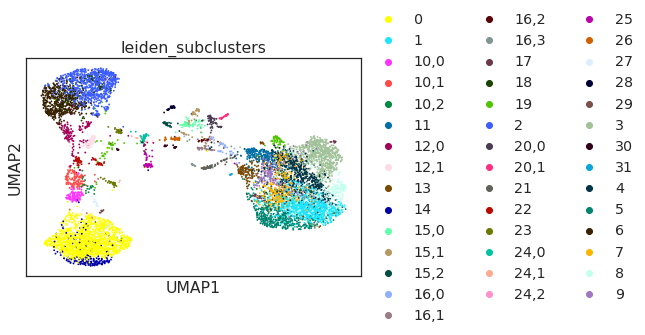

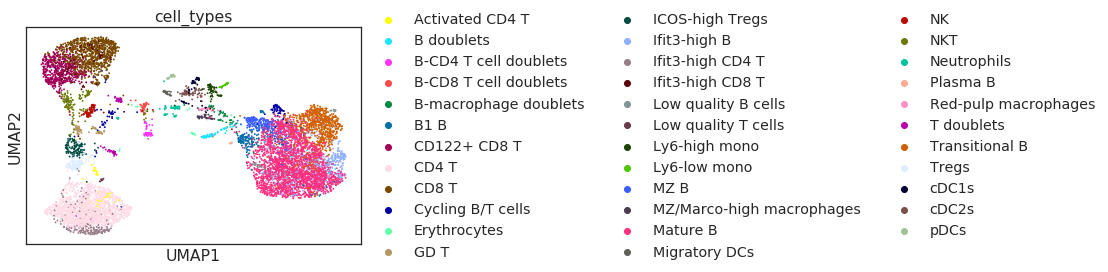

In [28]:
sc.pl.umap(
    post_adata, 
    color=["leiden_subclusters"], # This was generated on all of the data
    ncols=1
)

sc.pl.umap(
    post_adata, 
    color=["cell_types"], # This was generated on all of the data
    ncols=1
)

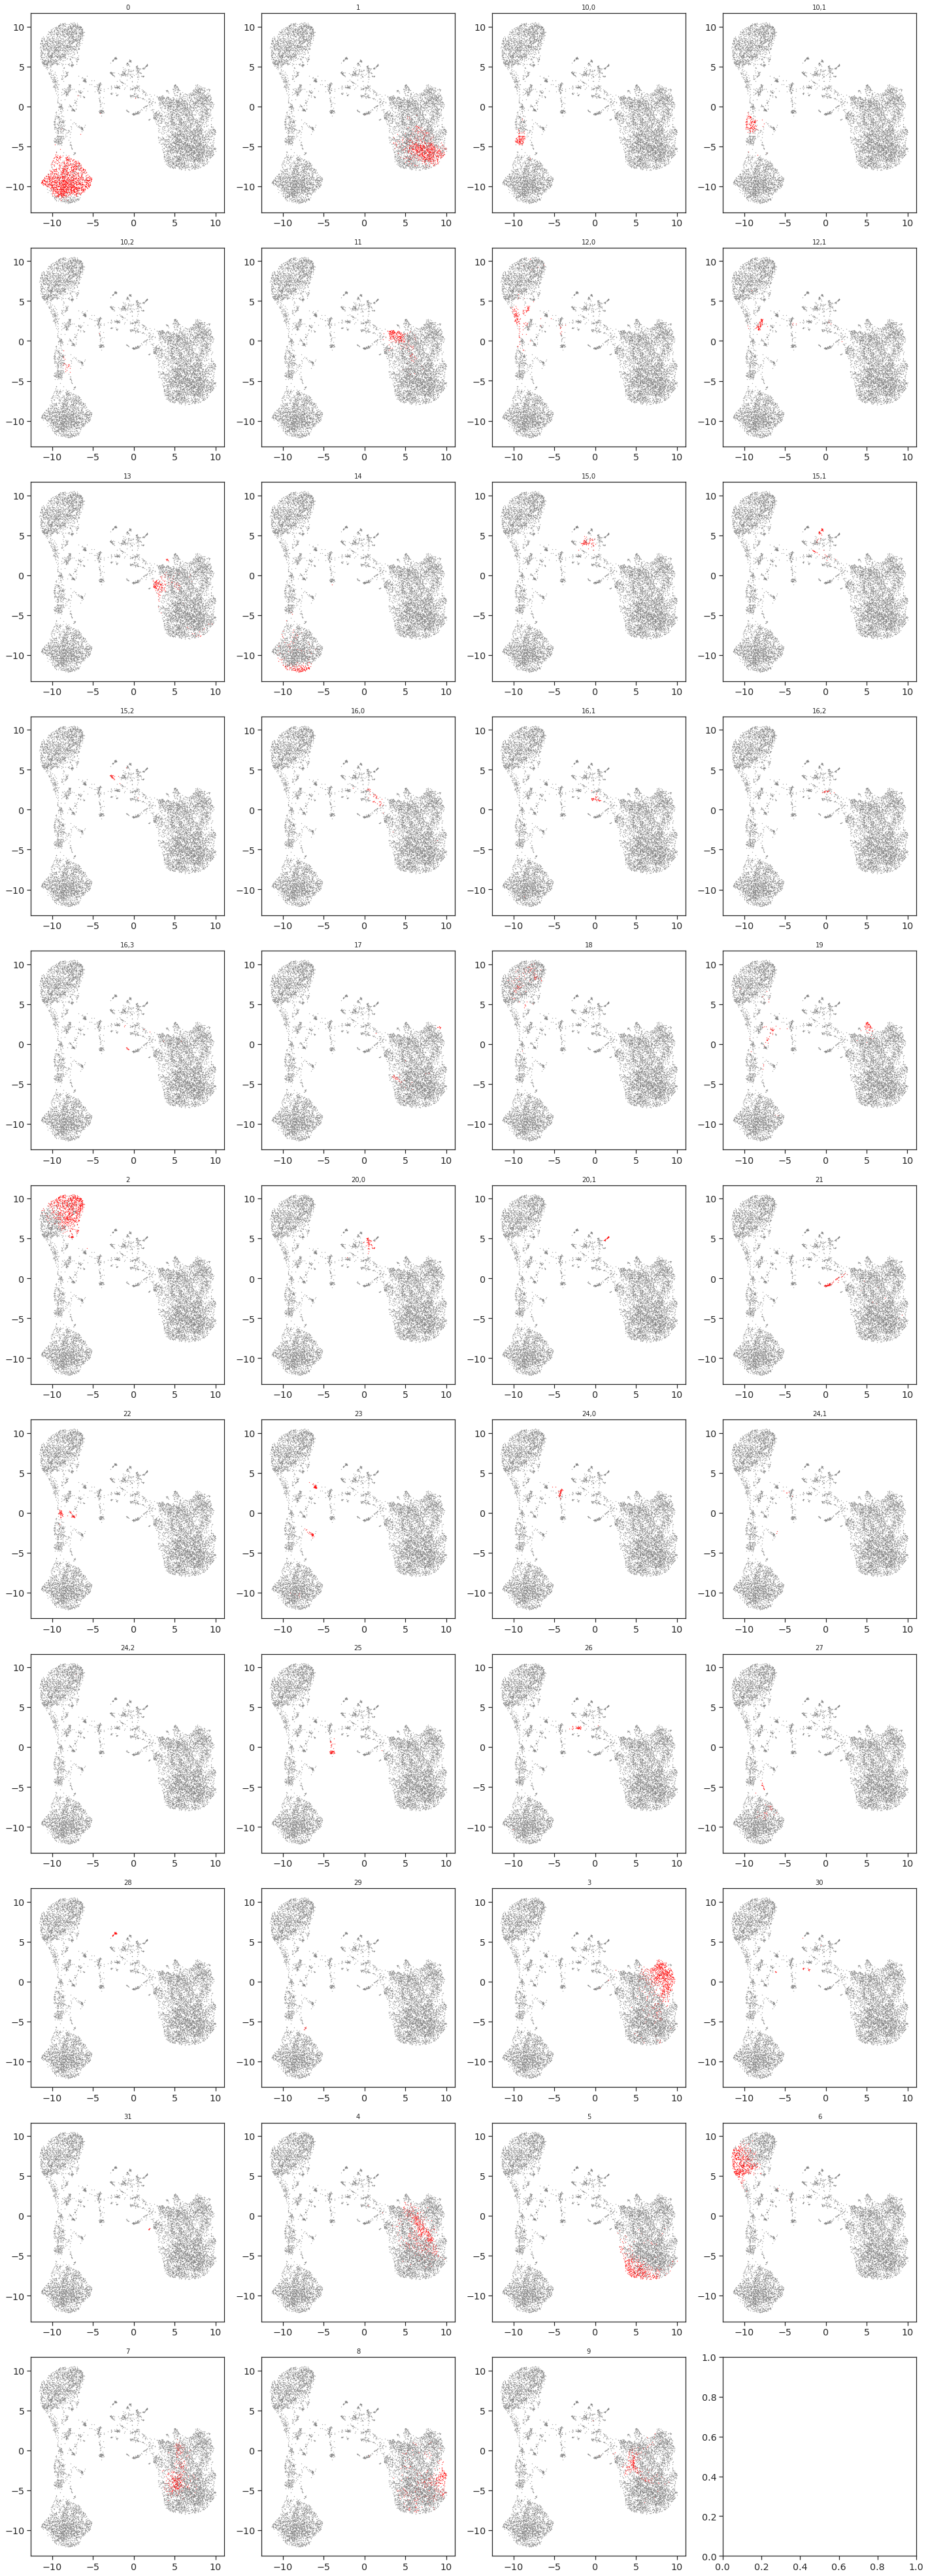

In [29]:
# Plot each cluster independently

fig, ax = plt.subplots(11, 4, figsize=(20, 55))
clusters = np.array((post_adata.obs["leiden_subclusters"])).ravel()
for c in range(len(np.unique(clusters))):
    ax.flat[c].scatter(x = post_adata.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 0], y = post_adata.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 1], s=.1,
                      c = "red")
    ax.flat[c].scatter(x = post_adata.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 0], y = post_adata.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 1], s=.1,
                      c = "grey")
    ax.flat[c].set_title(str(np.unique(clusters)[c]), fontsize = 10)

plt.tight_layout()

In [30]:
# Add denoised protein counts and foreground probabilities for plotting

for i, p in enumerate(dataset.protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{}".format(p)] = denoised_proteins[:, i] # each protein's count is its denoised value

In [31]:
post_adata

AnnData object with n_obs × n_vars = 8715 × 4005 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'ADT_4-1BBLigand(CD137L)_A0890_fore_prob', 'ADT_4-1BBLigand(CD137L)_A0890', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD105_A0812_fore_prob', 'ADT_CD105_A0812', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD107a(LAMP-1)_A0905_fore_prob', 'ADT_CD107a(LAMP-1)_A0905', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11b_A0014_fore_prob', 'ADT_CD11b_A0014', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD120b(TNFRTypeII-p75)_A0893_fore_prob', 'ADT_CD120b(TNFRTypeII-p75)_A0893', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD124(IL-4Ra)_A0916_fore_prob', 'ADT_CD124(

In [32]:
# Save anndata
post_adata.write("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_208day1.h5ad", compression="gzip")

In [13]:
# Read the previously saved anndata object (only need to generate post_adata once)
adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_208day1.h5ad")

In [14]:
adata

AnnData object with n_obs × n_vars = 8715 × 4005 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'ADT_4-1BBLigand(CD137L)_A0890_fore_prob', 'ADT_4-1BBLigand(CD137L)_A0890', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD105_A0812_fore_prob', 'ADT_CD105_A0812', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD107a(LAMP-1)_A0905_fore_prob', 'ADT_CD107a(LAMP-1)_A0905', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11b_A0014_fore_prob', 'ADT_CD11b_A0014', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD120b(TNFRTypeII-p75)_A0893_fore_prob', 'ADT_CD120b(TNFRTypeII-p75)_A0893', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD124(IL-4Ra)_A0916_fore_prob', 'ADT_CD124(

## Run GMM as baseline for background identification

In [15]:
# Run GMM on all proteins and all cells

log_protein = np.log1p(adata.obsm["protein_expression"])
post_probs = []
gmm_classifier = []
prob_back = []

for col in range(log_protein.shape[1]):
    gmm = GaussianMixture(n_components=2, random_state = 0) # covariance_type = 'tied'
    probs = gmm.fit(log_protein[:, col].reshape(-1, 1)).predict_proba(log_protein[:, col].reshape(-1, 1))
    
    # Make sure lower mode is first mean
    means = gmm.means_.ravel()
    mean_order = np.argsort(means)
    #print(means[mean_order])
    probs = probs[:, mean_order]
    # Only need the probability of being "on"
    post_probs.append(probs[:, 1])
    prob_back.append(probs[:, 0])
    
    labels = np.argmax(probs, axis=1).flatten()
    gmm_classifier.append(labels)
gmm_classifier = np.array(gmm_classifier).T # the prediction
post_probs = np.array(post_probs).T # equivalent of probability foreground in totalVI

prob_back = np.array(prob_back).T # equivalent of probability background in totalVI


## Scanpy normalization of RNA to plot raw data

In [16]:
# Normalize for library size (adjust to 10,000 counts/cell)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log the data
sc.pp.log1p(adata)

# Save log(raw) as adata.raw
adata.raw = adata

## Plot anecdotal cases for protein background decoupling

In [17]:
# Find matched RNA-protein names
encoded_proteins = pd.Series(adata.var["encode"][adata.var["encode"] != "None"], name = "Protein")

In [18]:
# Collect data for plotting: protein foreground and log(raw protein counts)
foreground = pd.DataFrame(np.array(adata.obs.filter(regex='fore_prob')), columns = adata.uns["totalVI_proteins"]) 
log_protein = np.log1p(adata.obsm["protein_expression"])

In [19]:
# For a given RNA, plot protein expression vs protein foreground, positive/negative cells on UMAP, RNA expression, and RNA/protein raw/denoised expression levels on UMAP.

def background_anecdote(RNA_name, save_figs):
    ### RNA_name is name of gene to plot
    ### save_figs = True or False
    
    fig_path = "/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_208day1/"
    
    # Collect data to plot
    protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]
    protein_fore = foreground[protein_name]
    rna_raw = pd.Series(adata.raw.X[:, adata.var.index == RNA_name].ravel())
    protein_raw = pd.Series(log_protein[:, adata.uns["totalVI_proteins"] == protein_name].ravel())
    rna_denoised = pd.Series(adata.obsm["denoised_genes"][:, adata.uns["totalVI_genes"] == RNA_name].ravel())
    protein_denoised = pd.Series(adata.obsm["denoised_proteins"][:, adata.uns["totalVI_proteins"] == protein_name].ravel())
    
    # Add to adata for plotting
    adata.obs[protein_name + "_raw"] = protein_raw.values
    adata.obs[RNA_name + "_denoised"] = rna_denoised.values
    adata.obs[protein_name + "_logdenoised"] = np.log1p(protein_denoised.values)

    
    # Find the threshold for foreground according to the GMM
    # GMM cutoff is the expression value at which 50% probability in mode 1, 50% in mode 2 (or closest to 50%)
    protein_idx = np.where(adata.uns["totalVI_proteins"] == protein_name)[0][0]
    cutoff_idx = (np.abs(post_probs[:, protein_idx] - 0.5)).argmin()

    gmm_cutoff = protein_raw[cutoff_idx] # Raw value that serves as the cutoff

    # Select cells to highlight
    pr_fore_highthresh = 0.8
    pr_fore_lowthresh = 0.2
    q1 = np.logical_and(protein_fore > pr_fore_highthresh, protein_raw > gmm_cutoff)
    q2 = np.logical_and(protein_fore > pr_fore_highthresh, protein_raw < gmm_cutoff)
    q3 = np.logical_and(protein_fore < pr_fore_lowthresh, protein_raw < gmm_cutoff)
    q4 = np.logical_and(protein_fore < pr_fore_lowthresh, protein_raw > gmm_cutoff)

    categories = [q1, q2, q3, q4]
    
    # Plot protein raw colored by quadrant
    fig = sns.jointplot(x = protein_raw, y = protein_fore, kind = "scatter", s = 1, color = ".4", rasterized = True,
                       marginal_kws = dict(bins = 50),
                       )
    fig.set_axis_labels("log(protein counts + 1)", "totalVI foreground probability")

    fig.ax_joint.scatter(x = protein_raw[q1], y = protein_fore[q1], s = 1, c = colors[1], rasterized = True)
    fig.ax_joint.scatter(x = protein_raw[q2], y = protein_fore[q2], s = 1, c = colors[0], rasterized = True)
    fig.ax_joint.scatter(x = protein_raw[q3], y = protein_fore[q3], s = 1, c = colors[3], rasterized = True)
    fig.ax_joint.scatter(x = protein_raw[q4], y = protein_fore[q4], s = 1, c = colors[2], rasterized = True)
    fig.ax_joint.axvline(x = gmm_cutoff, linestyle="--", c="black")
    fig.ax_marg_x.axvline(x = gmm_cutoff, linestyle="--", c="black")
    fig.ax_joint.set_ylim(0,1)
    fig.ax_joint.axhline(y = pr_fore_highthresh, linestyle="--", c="black")
    fig.ax_joint.axhline(y = pr_fore_lowthresh, linestyle="--", c="black")
    if save_figs == True:
        fig.savefig(fig_path + "%s_scatter_prforeground.pdf" % RNA_name, dpi = DPI)


    # Plot UMAP to highlight cells

    greycolor = "0.92"
    fig, ax = plt.subplots(2, 2, figsize=(5, 5))
    ptsize = .2
   
    ax.flat[0].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)
    ax.flat[1].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)
    ax.flat[2].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)
    ax.flat[3].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)

    ax.flat[1].scatter(x = adata.obsm["X_umap"][q1,0], y = adata.obsm["X_umap"][q1,1], s = ptsize, c = colors[1], rasterized = True)
    ax.flat[0].scatter(x = adata.obsm["X_umap"][q2,0], y = adata.obsm["X_umap"][q2,1], s = ptsize, c = colors[0], rasterized = True)
    ax.flat[2].scatter(x = adata.obsm["X_umap"][q3,0], y = adata.obsm["X_umap"][q3,1], s = ptsize, c = colors[3], rasterized = True)
    ax.flat[3].scatter(x = adata.obsm["X_umap"][q4,0], y = adata.obsm["X_umap"][q4,1], s = ptsize, c = colors[2], rasterized = True)
    
    ax.flat[0].set_xticklabels([])
    ax.flat[0].set_yticklabels([])
    ax.flat[0].tick_params(axis='both', which='both', length=0)
    ax.flat[1].set_xticklabels([])
    ax.flat[1].set_yticklabels([])
    ax.flat[1].tick_params(axis='both', which='both', length=0)
    ax.flat[2].set_xticklabels([])
    ax.flat[2].set_yticklabels([])
    ax.flat[2].tick_params(axis='both', which='both', length=0)
    ax.flat[3].set_xticklabels([])
    ax.flat[3].set_yticklabels([])
    ax.flat[3].tick_params(axis='both', which='both', length=0)
    sns.despine()

    plt.tight_layout()
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_highlightCells.pdf" % RNA_name, dpi = DPI)


    # Plot RNA histogram
    fig, ax = plt.subplots(2, 2, figsize=(5, 5), sharex = True) # sharex is needed for the x axis to match (4,1)

    ax.flat[1].hist(x = rna_raw[q1], density = True, color = colors[1])
    ax.flat[0].hist(x = rna_raw[q2], density = True, color = colors[0])
    ax.flat[2].hist(x = rna_raw[q3], density = True, color = colors[3])
    ax.flat[3].hist(x = rna_raw[q4], density = True, color = colors[2])
    sns.despine()
    plt.tight_layout()
    if save_figs == True:
        fig.savefig(fig_path + "%s_RNA_histogram.pdf" % RNA_name, dpi = DPI)

    
# Plot UMAPs colored by raw or denoised expression    
    # Plot RNA raw (log-library size normalized)
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        color=[RNA_name],
        title = [RNA_name + " RNA"],
        ncols=1, 
        frameon = False,
        ax = ax,
        color_map = "inferno"
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_RNA_raw.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')


    # Plot protein raw (log(counts + 1))
    protein_abbrev = protein_name.split("_")[1].split("(")[0]

    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        color=[protein_name + "_raw"], 
        title = [protein_abbrev], 
        ncols=1, 
        frameon = False,
        ax = ax,
        color_map = "inferno"
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_protein_raw.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

    
    # Plot RNA denoised
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        color=[RNA_name + "_denoised"], 
        title = [RNA_name + " RNA denoised"],
        ncols=1, 
        frameon = False,
        ax = ax,
        color_map = "inferno"
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_RNA_denoised.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

    # Plot protein denoised (log(denoised + 1))
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        color=[protein_name + "_logdenoised"],
        title = [protein_abbrev + " denoised"],  
        ncols=1, 
        frameon = False,
        ax = ax,
        color_map = "inferno"
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_protein_denoised.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

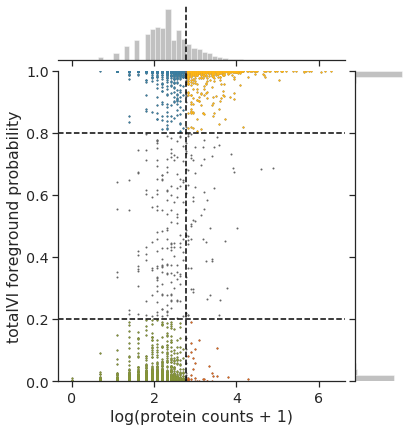

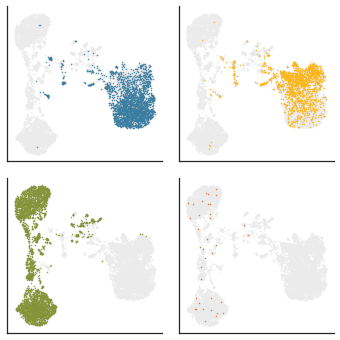

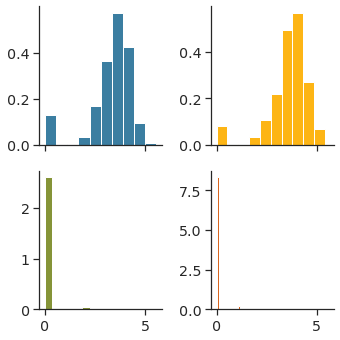

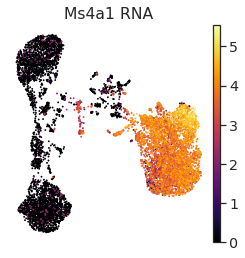

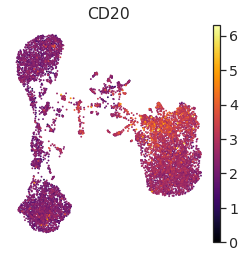

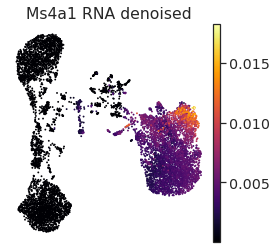

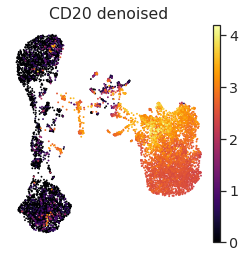

In [20]:
# Hard case
background_anecdote("Ms4a1", save_figs = False)

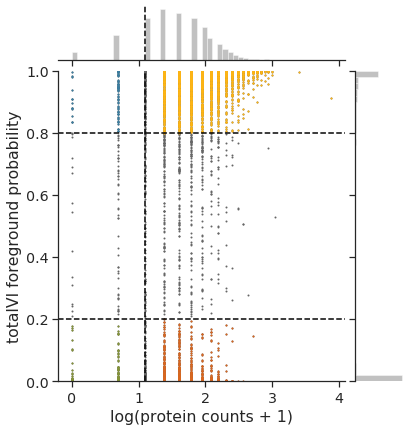

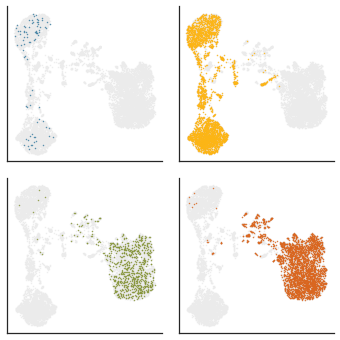

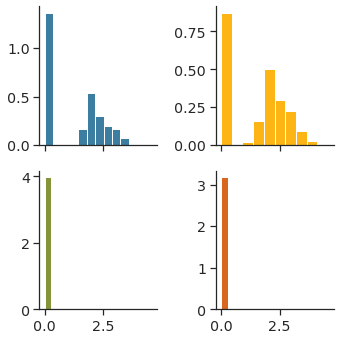

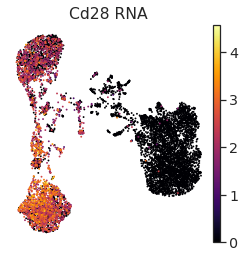

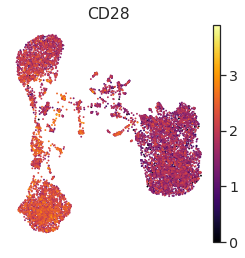

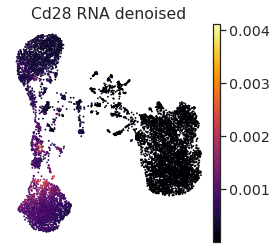

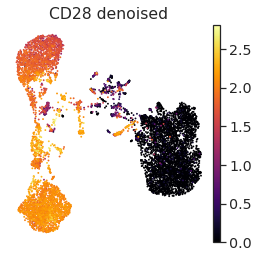

In [21]:
# Hard case
background_anecdote("Cd28", save_figs = False)

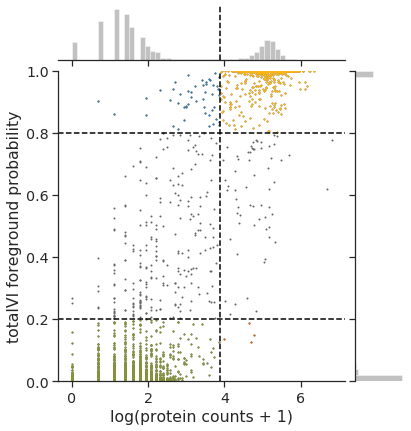

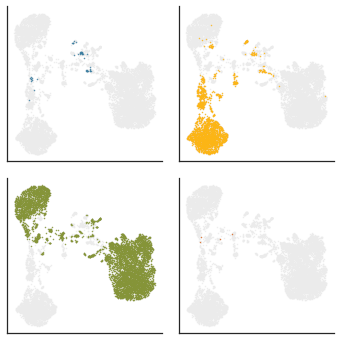

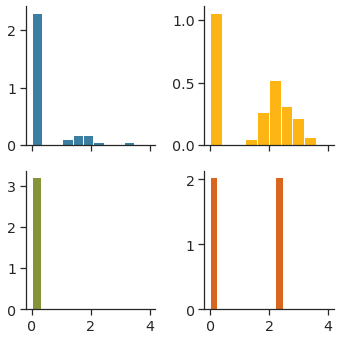

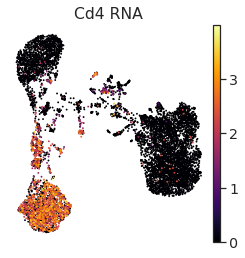

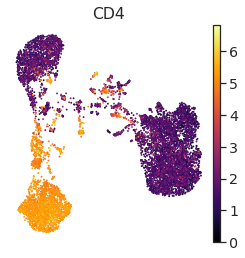

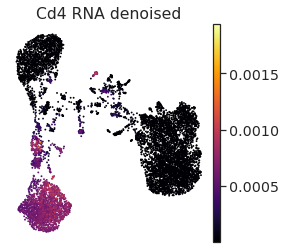

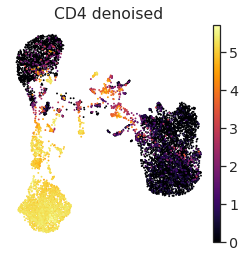

In [22]:
# Easy case
background_anecdote("Cd4", save_figs = False)

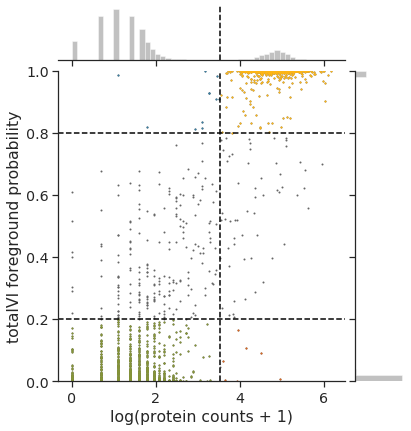

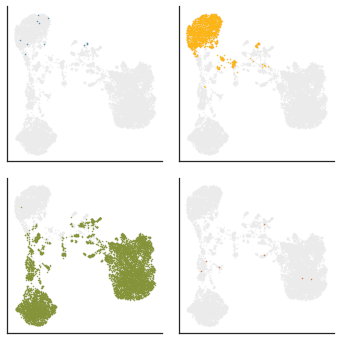

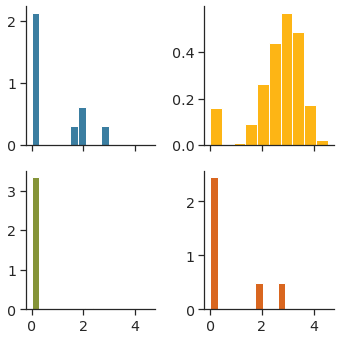

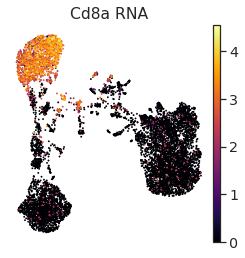

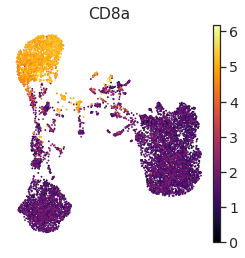

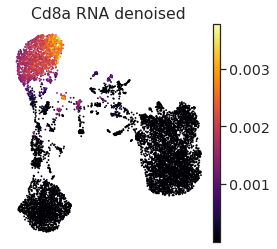

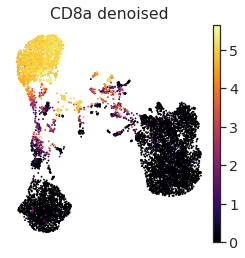

In [23]:
# Easy case
background_anecdote("Cd8a", save_figs = False)

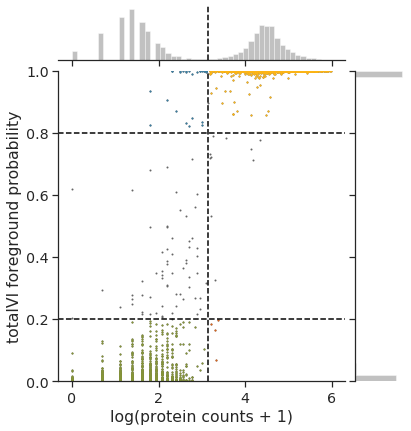

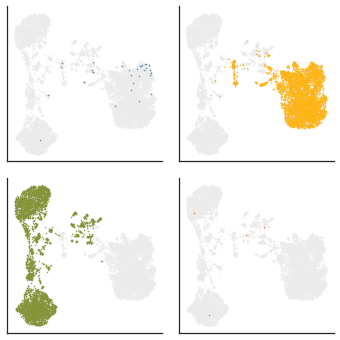

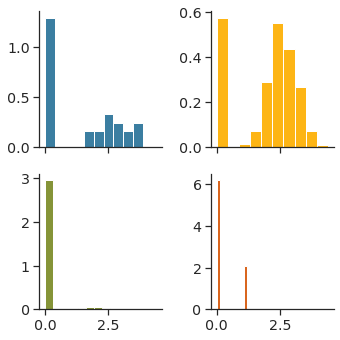

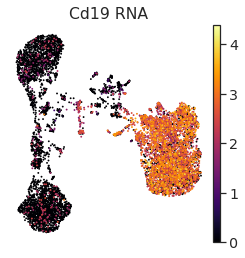

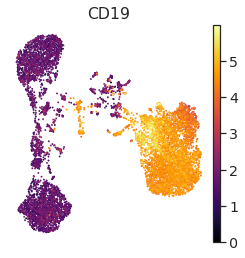

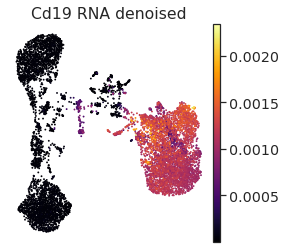

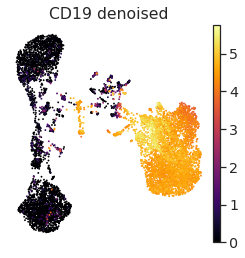

In [24]:
# Easy case
background_anecdote("Cd19", save_figs = False)

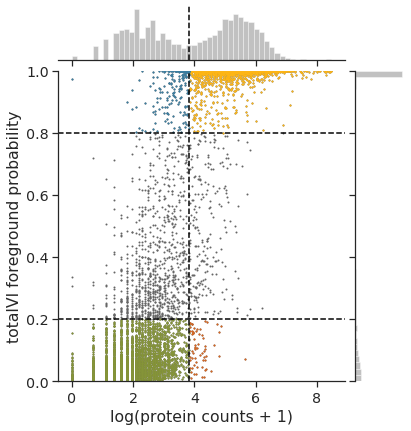

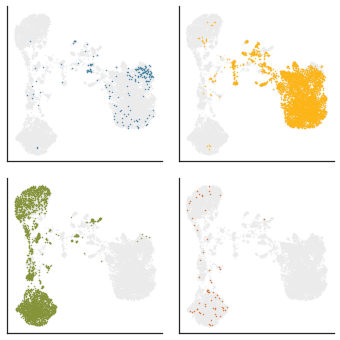

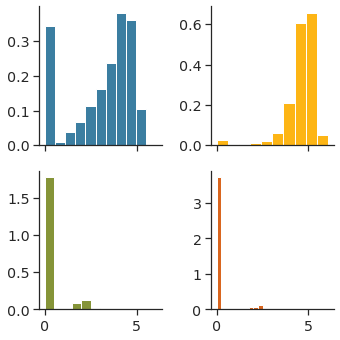

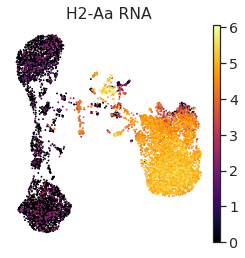

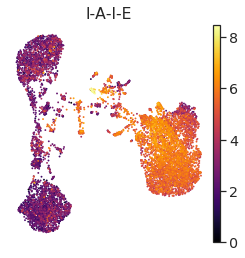

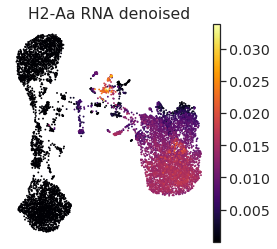

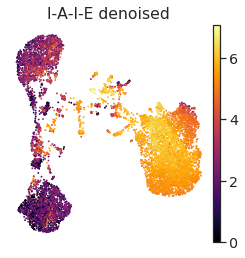

In [25]:
# Moderate case
background_anecdote("H2-Aa", save_figs = False)

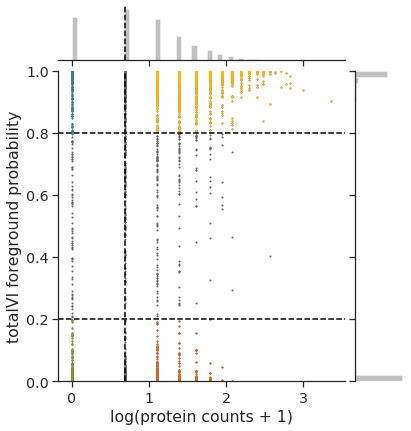

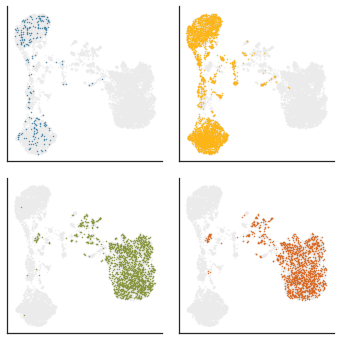

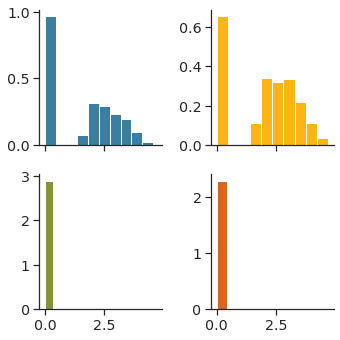

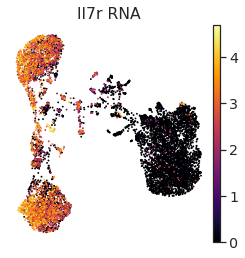

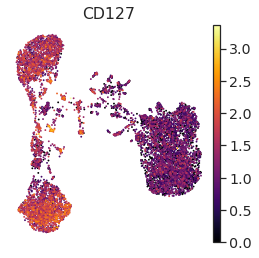

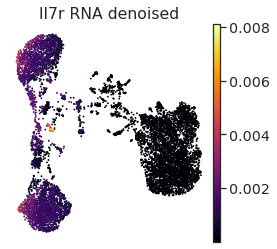

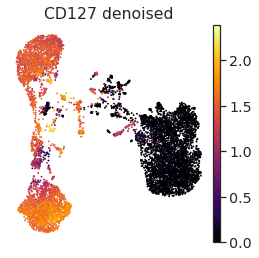

In [26]:
# Moderate case
background_anecdote("Il7r", save_figs = False)

## ROC curves of totalVI vs GMM classifier

In [33]:
# Cells types to test: B cells, CD4 T cells, CD8 T cells, all T cells
# Select cell types by cluster

# B cells
bcells = np.array([
    c in ["1", "3", "4", "5", "7", "8", "9", "11", "13"]
    for c in adata.obs["leiden_subclusters"]
])

# CD4 T cells (including Treg)
cd4tcells = np.array([
    c in ["0", "14", "27", "10,0", "10,1"]
    for c in adata.obs["leiden_subclusters"]
])

# Treg
treg = np.array([
    c in ["10,0", "10,1"]
    for c in adata.obs["leiden_subclusters"]
])

# All T cells
tcells = np.array([
    c in ["0", "14", "27", "10,0", "10,1", # CD4
         "2", "6", "18"] # CD8
    for c in adata.obs["leiden_subclusters"]
])

# CD8 T cells
cd8tcells = np.array([
    c in ["2", "6", "18"]
    for c in adata.obs["leiden_subclusters"]
])

In [34]:
# Sets of cells to test (restrict to B/T)

all_bt = tcells | bcells

In [35]:
# GMM foreground dataframe with protein names for all cells, all proteins

gmm_fore = pd.DataFrame(post_probs, columns = adata.uns["protein_names"])

### Plot and save three example ROC curves

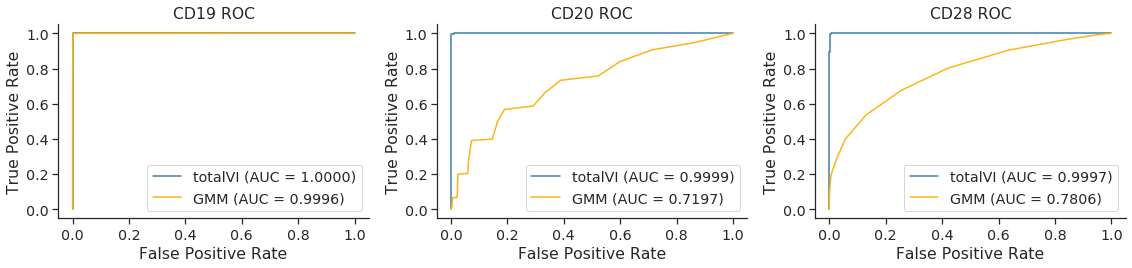

In [36]:
# Plot ROC curves
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

cells = all_bt

###### First plot: CD19
RNA_name = "Cd19"
protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

# Calculate ROC AUC
totalvi_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = foreground[protein_name][cells])
gmm_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = foreground[protein_name][cells])
ax.flat[0].plot(fpr, tpr, label = "totalVI (AUC = {0:0.4f})" "".format(totalvi_auc))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])
ax.flat[0].plot(fpr, tpr, label = "GMM (AUC = {0:0.4f})" "".format(gmm_auc))

ax.flat[0].set_xlabel("False Positive Rate")
ax.flat[0].set_ylabel("True Positive Rate")
protein_title = protein_name.split("_")[1].split("(")[0]

ax.flat[0].set_title(protein_title + " ROC")
ax.flat[0].legend()


###### Second plot: CD20
RNA_name = "Ms4a1"
protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

# Calculate ROC AUC
totalvi_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = foreground[protein_name][cells])
gmm_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = foreground[protein_name][cells])
ax.flat[1].plot(fpr, tpr, label = "totalVI (AUC = {0:0.4f})" "".format(totalvi_auc))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])
ax.flat[1].plot(fpr, tpr, label = "GMM (AUC = {0:0.4f})" "".format(gmm_auc))

ax.flat[1].set_xlabel("False Positive Rate")
ax.flat[1].set_ylabel("True Positive Rate")
protein_title = protein_name.split("_")[1].split("(")[0]

ax.flat[1].set_title(protein_title + " ROC")
ax.flat[1].legend()


###### Third plot: CD28
RNA_name = "Cd28"
protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

# Calculate ROC AUC
totalvi_auc = sklearn.metrics.roc_auc_score(y_true = tcells[cells], y_score = foreground[protein_name][cells])
gmm_auc = sklearn.metrics.roc_auc_score(y_true = tcells[cells], y_score = gmm_fore[protein_name][cells])

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = tcells[cells], y_score = foreground[protein_name][cells])
ax.flat[2].plot(fpr, tpr, label = "totalVI (AUC = {0:0.4f})" "".format(totalvi_auc))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = tcells[cells], y_score = gmm_fore[protein_name][cells])
ax.flat[2].plot(fpr, tpr, label = "GMM (AUC = {0:0.4f})" "".format(gmm_auc))

ax.flat[2].set_xlabel("False Positive Rate")
ax.flat[2].set_ylabel("True Positive Rate")
protein_title = protein_name.split("_")[1].split("(")[0]

ax.flat[2].set_title(protein_title + " ROC")
ax.flat[2].legend()

sns.despine()
plt.tight_layout()


#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/ROC_CD19_CD20_CD28.pdf", dpi=DPI, bbox_inches='tight')

### Classification of known marker proteins

In [37]:
# Proteins to test and cells to test on

markers = {"bcells": ["ADT_CD19_A0093", "ADT_CD45R-B220_A0103", "ADT_CD20_A0192", "ADT_I-A-I-E_A0117"], 
           "tcells": ["ADT_CD5_A0111", "ADT_TCRbchain_A0120", "ADT_CD90.2_A0075", "ADT_CD28_A0204"], 
           "cd4tcells":["ADT_CD4_A0001"], 
           "cd8tcells":["ADT_CD8a_A0002", "ADT_CD8b(Ly-3)_A0230"]}

In [38]:
# For each marker protein, find the AUC ROC score for classification

cells = all_bt # cells to include in classification
cell_types_print = {"bcells": "B cells",
                   "tcells": "T cells",
                   "cd4tcells": "CD4 T cells",
                   "cd8tcells": "CD8 T cells"}

# save results
auc_results = pd.DataFrame(columns = ["Cell type", "Protein", 
                                      "totalVI ROC AUC", "GMM ROC AUC"])

for cell_type in markers:
    for protein_name in markers[cell_type]:
        true_cells = eval(cell_type) # convert from string to variable to get list of cells

        # ROC AUC
        totalvi_roc = sklearn.metrics.roc_auc_score(y_true = true_cells[cells], y_score = foreground[protein_name][cells])
        gmm_roc = sklearn.metrics.roc_auc_score(y_true = true_cells[cells], y_score = gmm_fore[protein_name][cells])
        
        # Add results to dataframe
        auc_results = auc_results.append([{"Cell type":cell_types_print[cell_type], 
                                           "Protein":protein_name.split("_")[1].split("(")[0], 
                                           "totalVI ROC AUC":totalvi_roc, "GMM ROC AUC":gmm_roc, 
                                           }])

In [39]:
auc_results

Cell type     Protein  totalVI ROC AUC  GMM ROC AUC
0      B cells        CD19         0.999999     0.999606
0      B cells  CD45R-B220         0.999945     0.997338
0      B cells        CD20         0.999933     0.719735
0      B cells     I-A-I-E         0.998401     0.978357
0      T cells         CD5         0.999853     0.996697
0      T cells   TCRbchain         0.999998     0.994395
0      T cells      CD90.2         1.000000     0.998857
0      T cells        CD28         0.999703     0.780581
0  CD4 T cells         CD4         0.999956     0.996635
0  CD8 T cells        CD8a         0.999997     0.999163
0  CD8 T cells        CD8b         0.999996     0.999368

In [40]:
# totalVI has higher AUC for all proteins

auc_results[["totalVI ROC AUC"]].values >auc_results[["GMM ROC AUC"]].values

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

## Normalize with isotype controls

* Find the isotype control for each marker protein of interest
* Normalize raw data by isotype control (Cumulus)
* Rerun GMM on normalized data

In [41]:
# Find isotype controls for the following marker proteins

marker_proteins = [marker for sublist in markers.values() for marker in sublist]
marker_proteins

['ADT_CD19_A0093',
 'ADT_CD45R-B220_A0103',
 'ADT_CD20_A0192',
 'ADT_I-A-I-E_A0117',
 'ADT_CD5_A0111',
 'ADT_TCRbchain_A0120',
 'ADT_CD90.2_A0075',
 'ADT_CD28_A0204',
 'ADT_CD4_A0001',
 'ADT_CD8a_A0002',
 'ADT_CD8b(Ly-3)_A0230']

In [42]:
# Protein: isotype control

isotype_controls = {'ADT_CD19_A0093': "ADT_IsotypeCtrlRatIgG2a_k_A0238", # https://www.biolegend.com/en-us/products/apc-anti-mouse-cd19-antibody-1526
 'ADT_CD45R-B220_A0103': "ADT_IsotypeCtrlRatIgG2a_k_A0238", # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-human-cd45r-b220-antibody-2707
 'ADT_CD20_A0192': "ADT_IsotypeCtrlRatIgG2b_k_A0095", # https://www.biolegend.com/en-us/products/alexa-fluor-647-anti-mouse-cd20-antibody-12238
 'ADT_I-A-I-E_A0117': "ADT_IsotypeCtrlRatIgG2b_k_A0095", # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-i-a-i-e-antibody-3134   
 'ADT_CD5_A0111': "ADT_IsotypeCtrlRatIgG2a_k_A0238", # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-cd5-antibody-3198
 'ADT_TCRbchain_A0120': "ADT_IsotypeCtrlArm.HamsterIgG_A0241", # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-tcr-beta-chain-antibody-2713
 'ADT_CD90.2_A0075': "ADT_IsotypeCtrlRatIgG2b_k_A0095", # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-cd90-2-antibody-3124
 #'ADT_CD28_A0204': None, # syrian hamster igg, https://www.biolegend.com/en-us/products/apc-anti-mouse-cd28-antibody-112
 'ADT_CD4_A0001': "ADT_IsotypeCtrlRatIgG2a_k_A0238", # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-cd4-antibody-2697
 'ADT_CD8a_A0002': "ADT_IsotypeCtrlRatIgG2a_k_A0238", # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-cd8a-antibody-2698
 'ADT_CD8b(Ly-3)_A0230': "ADT_IsotypeCtrlRatIgG2a_k_A0238"} # https://www.biolegend.com/en-us/products/alexa-fluor-488-anti-mouse-cd8a-antibody-2698

In [43]:
isotype_names = [marker for marker in isotype_controls.values()]

In [44]:
adata_isotype

AnnData object with n_obs × n_vars = 8715 × 13553 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'
    uns: 'protein_names', 'version'
    obsm: 'protein_expression'

### Cumulus normalization with isotype controls

1. log(fold change) between feature UMI counts and its IgG control (add 1 to both).
2. Take max of above and 0 (if expression is less than IgG, call it zero expression).
3. If there is not data for the IgG control, take log(UMI counts + 1)

In [48]:
# Normalize raw protein data by Cumulus method

norm_prot = [] # following the Cumulus normalization method
norm_prot_mod = [] # modified Cumulus normalization (with IgG, no zero)
IgG_name = []

for protein in marker_proteins:
    
    # raw expression of the protein
    exp_prot = np.array(adata_isotype.obsm["protein_expression"][:, np.where(adata_isotype.uns["protein_names"] == protein)[0][0]])
    
    if protein in isotype_controls:
        IgG = isotype_controls[protein] # find the correct isotype control
        igg_name = re.sub("ADT_", "", re.sub("_A\d\d\d\d", "", IgG))
        IgG_name.append(igg_name)
        exp_isotype = np.array(adata_isotype.obsm["protein_expression"][:, np.where(adata_isotype.uns["protein_names"] == IgG)[0][0]])
        expr = np.maximum(np.log((exp_prot + 1)/(exp_isotype + 1)), 0) # normalized expression: max(log(prot/IgG), 0)
        expr_mod = np.log((exp_prot + 1)/(exp_isotype + 1)) # normalized expression: log(prot/IgG)

        
    else:
        expr = np.log(exp_prot + 1) # normalized expression: log(prot) if no isotype control is available
        expr_mod = expr
        IgG_name.append("NA")
        
    norm_prot.append(expr)   
    norm_prot_mod.append(expr_mod)
    

In [49]:
IgG_name

['IsotypeCtrlRatIgG2a_k',
 'IsotypeCtrlRatIgG2a_k',
 'IsotypeCtrlRatIgG2b_k',
 'IsotypeCtrlRatIgG2b_k',
 'IsotypeCtrlRatIgG2a_k',
 'IsotypeCtrlArm.HamsterIgG',
 'IsotypeCtrlRatIgG2b_k',
 'NA',
 'IsotypeCtrlRatIgG2a_k',
 'IsotypeCtrlRatIgG2a_k',
 'IsotypeCtrlRatIgG2a_k']

In [53]:
# create dataframe
norm_prot_df = pd.DataFrame(np.array(norm_prot).T, columns = marker_proteins)
norm_prot_mod_df = pd.DataFrame(np.array(norm_prot_mod).T, columns = marker_proteins)

### Rerun GMM after Cumulus normalization

In [54]:
# Run GMM on all proteins and all cells (standard log normalization)

log_protein = np.log1p(adata.obsm["protein_expression"])
post_probs = []
gmm_classifier = []
for col in range(log_protein.shape[1]):
    gmm = GaussianMixture(n_components=2, random_state = 0)
    probs = gmm.fit(log_protein[:, col].reshape(-1, 1)).predict_proba(log_protein[:, col].reshape(-1, 1))
    
    # Make sure lower mode is first mean
    means = gmm.means_.ravel()
    mean_order = np.argsort(means)
    probs = probs[:, mean_order]
    # Only need the probability of being "on"
    post_probs.append(probs[:, 1])
    labels = np.argmax(probs, axis=1).flatten()
    gmm_classifier.append(labels)
gmm_classifier = np.array(gmm_classifier).T # the prediction
post_probs = np.array(post_probs).T # equivalent of probability foreground in totalVI


In [55]:
# Run GMM on normalized proteins (Cumulus method)

norm_prot_array = np.array(norm_prot).T
post_probs_norm = []
gmm_classifier_norm = []

for col in range(norm_prot_array.shape[1]):
    gmm = GaussianMixture(n_components=2, random_state = 0)
    probs = gmm.fit(norm_prot_array[:, col].reshape(-1, 1)).predict_proba(norm_prot_array[:, col].reshape(-1, 1))
    
    # Make sure lower mode is first mean
    means = gmm.means_.ravel()
    mean_order = np.argsort(means)
    #print(means[mean_order])
    probs = probs[:, mean_order]
    # Only need the probability of being "on"
    post_probs_norm.append(probs[:, 1])
    labels = np.argmax(probs, axis=1).flatten()
    gmm_classifier_norm.append(labels)
gmm_classifier_norm1 = np.array(gmm_classifier_norm).T # the prediction
post_probs_norm1 = np.array(post_probs_norm).T # equivalent of probability foreground in totalVI

In [56]:
# Run GMM on normalized proteins (modified Cumulus method)

norm_prot_array = np.array(norm_prot_mod).T
post_probs_norm = []
gmm_classifier_norm = []

for col in range(norm_prot_array.shape[1]):
    gmm = GaussianMixture(n_components=2, random_state = 0)
    probs = gmm.fit(norm_prot_array[:, col].reshape(-1, 1)).predict_proba(norm_prot_array[:, col].reshape(-1, 1))
    
    # Make sure lower mode is first mean
    means = gmm.means_.ravel()
    mean_order = np.argsort(means)
    #print(means[mean_order])
    probs = probs[:, mean_order]
    # Only need the probability of being "on"
    post_probs_norm.append(probs[:, 1])
    labels = np.argmax(probs, axis=1).flatten()
    gmm_classifier_norm.append(labels)
gmm_classifier_norm2 = np.array(gmm_classifier_norm).T # the prediction
post_probs_norm2 = np.array(post_probs_norm).T # equivalent of probability foreground in totalVI

In [72]:
gmm_fore_norm1 = pd.DataFrame(post_probs_norm1, columns = marker_proteins)
gmm_fore_norm2 = pd.DataFrame(post_probs_norm2, columns = marker_proteins)

In [59]:
# For each marker protein, find the AUC ROC score for classification

cells = all_bt # cells to include in classification
cell_types_print = {"bcells": "B cells",
                   "tcells": "T cells",
                   "cd4tcells": "CD4 T cells",
                   "cd8tcells": "CD8 T cells"}

# save results
auc_results_norm = pd.DataFrame(columns = ["Cell type", "Protein", 
                                      "totalVI ROC AUC", "GMM norm1 ROC AUC",
                                          "GMM norm2 ROC AUC"])

for cell_type in markers:
    for protein_name in markers[cell_type]:
        true_cells = eval(cell_type) # convert from string to variable to get list of cells

        # ROC AUC
        totalvi_roc = sklearn.metrics.roc_auc_score(y_true = true_cells[cells], y_score = foreground[protein_name][cells])
        gmm_roc_norm1 = sklearn.metrics.roc_auc_score(y_true = true_cells[cells], y_score = gmm_fore_norm1[protein_name][cells])
        gmm_roc_norm2 = sklearn.metrics.roc_auc_score(y_true = true_cells[cells], y_score = gmm_fore_norm2[protein_name][cells])

        # Add results to dataframe
        auc_results_norm = auc_results_norm.append([{"Cell type":cell_types_print[cell_type], 
                                           "Protein":protein_name.split("_")[1].split("(")[0], 
                                           "totalVI ROC AUC":totalvi_roc, "GMM norm1 ROC AUC":gmm_roc_norm1, 
                                                "GMM norm2 ROC AUC":gmm_roc_norm2
                                           }], sort = False)

In [60]:
auc_results_norm

Cell type     Protein  totalVI ROC AUC  GMM norm1 ROC AUC  \
0      B cells        CD19         0.999999           0.998849   
0      B cells  CD45R-B220         0.999945           0.995928   
0      B cells        CD20         0.999933           0.752866   
0      B cells     I-A-I-E         0.998401           0.969516   
0      T cells         CD5         0.999853           0.993870   
0      T cells   TCRbchain         0.999998           0.772583   
0      T cells      CD90.2         1.000000           0.831607   
0      T cells        CD28         0.999703           0.780581   
0  CD4 T cells         CD4         0.999956           0.996625   
0  CD8 T cells        CD8a         0.999997           0.795203   
0  CD8 T cells        CD8b         0.999996           0.860700   

   GMM norm2 ROC AUC  
0           0.998849  
0           0.996153  
0           0.749423  
0           0.969558  
0           0.993870  
0           0.976244  
0           0.998403  
0           0.780581  
0           0.996686  
0           0.998922  
0           0.998986

In [61]:
auc_results.insert(2, "Isotype Control", IgG_name)

In [62]:
auc_results[["GMM norm1 ROC AUC"]] = auc_results_norm[["GMM norm1 ROC AUC"]]
auc_results[["GMM norm2 ROC AUC"]] = auc_results_norm[["GMM norm2 ROC AUC"]]

In [63]:
auc_results # Many predictions get worse after normalizing with isotype controls

Cell type     Protein            Isotype Control  totalVI ROC AUC  \
0      B cells        CD19      IsotypeCtrlRatIgG2a_k         0.999999   
0      B cells  CD45R-B220      IsotypeCtrlRatIgG2a_k         0.999945   
0      B cells        CD20      IsotypeCtrlRatIgG2b_k         0.999933   
0      B cells     I-A-I-E      IsotypeCtrlRatIgG2b_k         0.998401   
0      T cells         CD5      IsotypeCtrlRatIgG2a_k         0.999853   
0      T cells   TCRbchain  IsotypeCtrlArm.HamsterIgG         0.999998   
0      T cells      CD90.2      IsotypeCtrlRatIgG2b_k         1.000000   
0      T cells        CD28                         NA         0.999703   
0  CD4 T cells         CD4      IsotypeCtrlRatIgG2a_k         0.999956   
0  CD8 T cells        CD8a      IsotypeCtrlRatIgG2a_k         0.999997   
0  CD8 T cells        CD8b      IsotypeCtrlRatIgG2a_k         0.999996   

   GMM ROC AUC  GMM norm1 ROC AUC  GMM norm2 ROC AUC  
0     0.999606           0.998849           0.998849  
0     0.997338           0.995928           0.996153  
0     0.719735           0.752866           0.749423  
0     0.978357           0.969516           0.969558  
0     0.996697           0.993870           0.993870  
0     0.994395           0.772583           0.976244  
0     0.998857           0.831607           0.998403  
0     0.780581           0.780581           0.780581  
0     0.996635           0.996625           0.996686  
0     0.999163           0.795203           0.998922  
0     0.999368           0.860700           0.998986

In [64]:
# Truncate all results

auc_str = auc_results.astype(str)
for col in auc_str.iloc[:, 3:].columns:
    vals = auc_str[col]
    trunc_vals = [val[0:6] for val in vals] # Truncate to 4 decimal points so that we can still see that totalVI is highest
    #print(trunc_vals)
    auc_str[col] = trunc_vals
    
auc_str

Cell type     Protein            Isotype Control totalVI ROC AUC  \
0      B cells        CD19      IsotypeCtrlRatIgG2a_k          0.9999   
0      B cells  CD45R-B220      IsotypeCtrlRatIgG2a_k          0.9999   
0      B cells        CD20      IsotypeCtrlRatIgG2b_k          0.9999   
0      B cells     I-A-I-E      IsotypeCtrlRatIgG2b_k          0.9984   
0      T cells         CD5      IsotypeCtrlRatIgG2a_k          0.9998   
0      T cells   TCRbchain  IsotypeCtrlArm.HamsterIgG          0.9999   
0      T cells      CD90.2      IsotypeCtrlRatIgG2b_k          0.9999   
0      T cells        CD28                         NA          0.9997   
0  CD4 T cells         CD4      IsotypeCtrlRatIgG2a_k          0.9999   
0  CD8 T cells        CD8a      IsotypeCtrlRatIgG2a_k          0.9999   
0  CD8 T cells        CD8b      IsotypeCtrlRatIgG2a_k          0.9999   

  GMM ROC AUC GMM norm1 ROC AUC GMM norm2 ROC AUC  
0      0.9996            0.9988            0.9988  
0      0.9973            0.9959            0.9961  
0      0.7197            0.7528            0.7494  
0      0.9783            0.9695            0.9695  
0      0.9966            0.9938            0.9938  
0      0.9943            0.7725            0.9762  
0      0.9988            0.8316            0.9984  
0      0.7805            0.7805            0.7805  
0      0.9966            0.9966            0.9966  
0      0.9991            0.7952            0.9989  
0      0.9993            0.8606            0.9989

In [65]:
print(auc_str.to_latex(index = False))

\begin{tabular}{lllllll}
\toprule
   Cell type &     Protein &            Isotype Control & totalVI ROC AUC & GMM ROC AUC & GMM norm1 ROC AUC & GMM norm2 ROC AUC \\
\midrule
     B cells &        CD19 &      IsotypeCtrlRatIgG2a\_k &          0.9999 &      0.9996 &            0.9988 &            0.9988 \\
     B cells &  CD45R-B220 &      IsotypeCtrlRatIgG2a\_k &          0.9999 &      0.9973 &            0.9959 &            0.9961 \\
     B cells &        CD20 &      IsotypeCtrlRatIgG2b\_k &          0.9999 &      0.7197 &            0.7528 &            0.7494 \\
     B cells &     I-A-I-E &      IsotypeCtrlRatIgG2b\_k &          0.9984 &      0.9783 &            0.9695 &            0.9695 \\
     T cells &         CD5 &      IsotypeCtrlRatIgG2a\_k &          0.9998 &      0.9966 &            0.9938 &            0.9938 \\
     T cells &   TCRbchain &  IsotypeCtrlArm.HamsterIgG &          0.9999 &      0.9943 &            0.7725 &            0.9762 \\
     T cells &      CD90.2 &      I

In [66]:
# Find which performs best
auc_vals = auc_results.iloc[:, 3:]
auc_vals.idxmax(axis = 1) # totalVI still performs best relative to IgG normalization

0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
0    totalVI ROC AUC
dtype: object

In [67]:
# Find highest performer of GMM
auc_vals = auc_results.iloc[:, 4:]
auc_vals.idxmax(axis = 1)

0          GMM ROC AUC
0          GMM ROC AUC
0    GMM norm1 ROC AUC
0          GMM ROC AUC
0          GMM ROC AUC
0          GMM ROC AUC
0          GMM ROC AUC
0          GMM ROC AUC
0    GMM norm2 ROC AUC
0          GMM ROC AUC
0          GMM ROC AUC
dtype: object

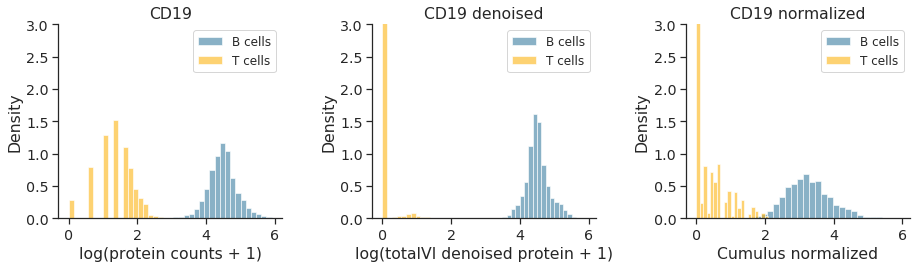

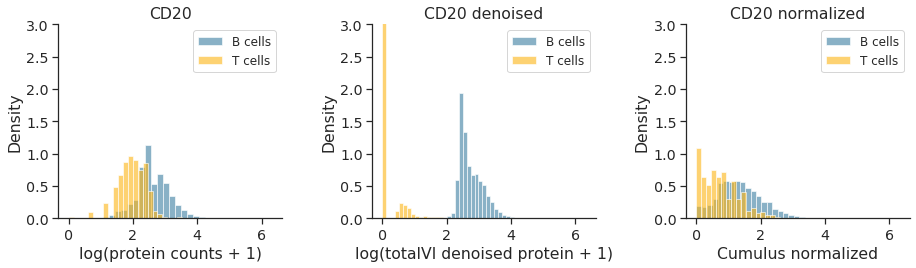

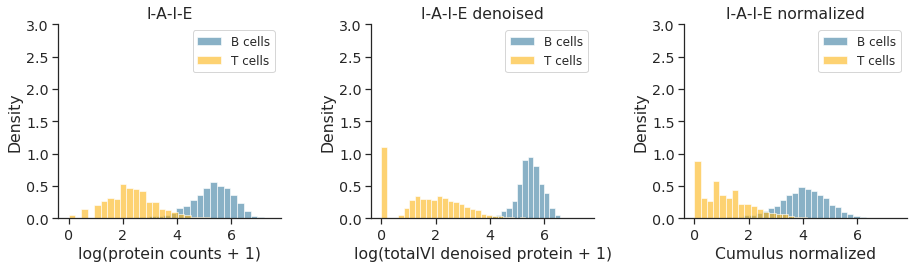

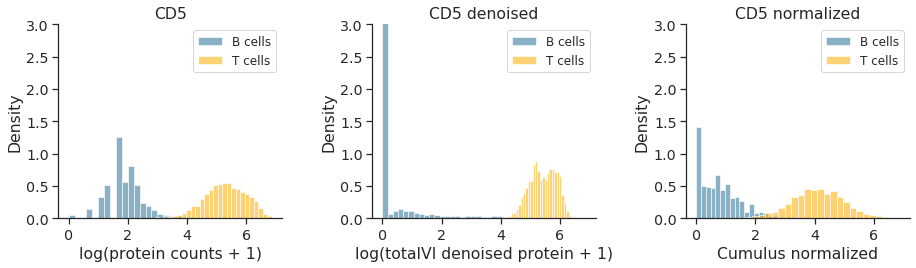

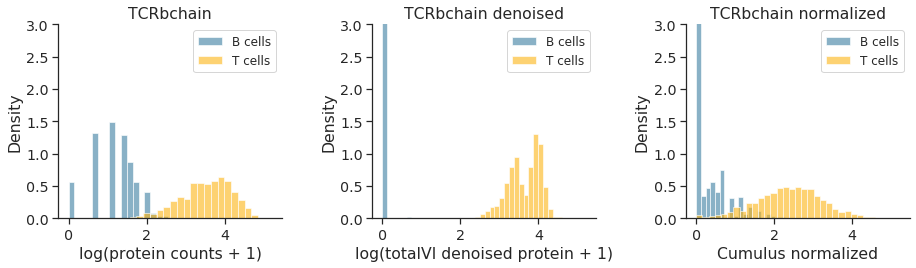

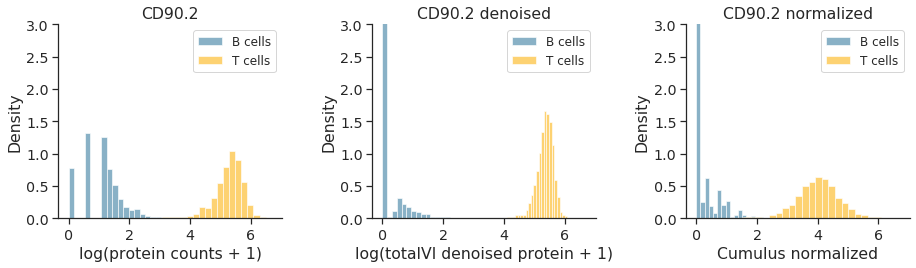

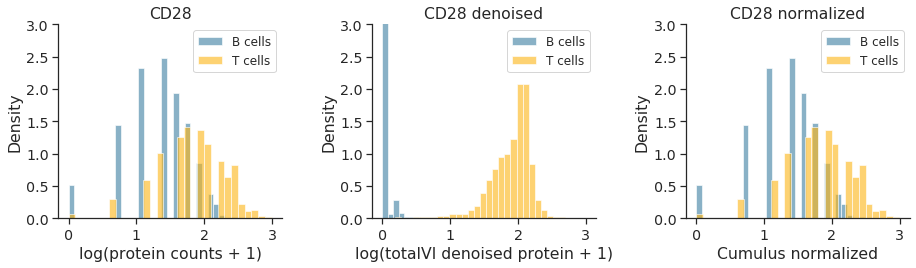

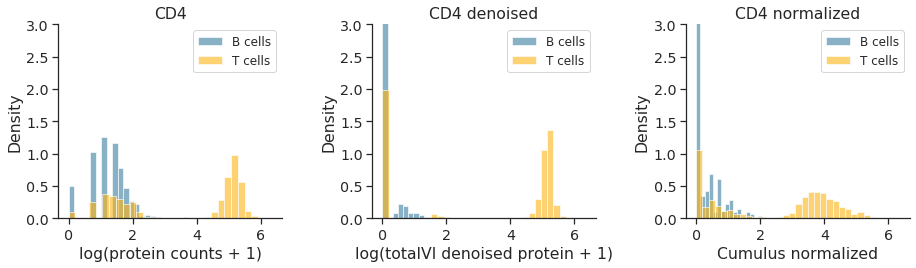

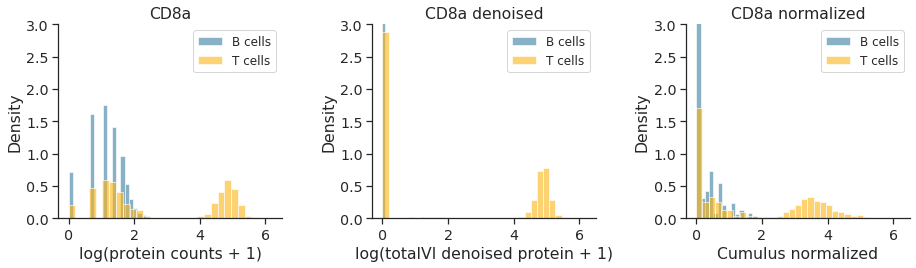

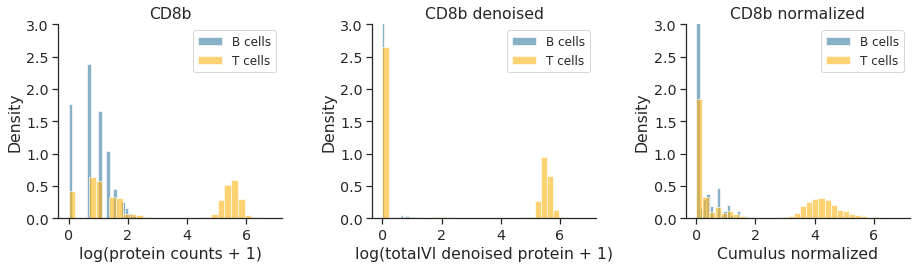

In [68]:
# Plot histograms of raw vs denoised expression in B cells and T cells for a few example proteins

for RNA_name in ["Cd19", "Ms4a1", "H2-Aa", "Cd5", "Trbc1", "Thy1", "Cd28", "Cd4", "Cd8a", "Cd8b1"]:
    fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharex = True, ) # 1,2 9,4
    num_bins = 30
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]
    
    # Plot raw proteins (log(counts + 1))
    
    # B cells
    ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )
    
    ax[0].legend(loc='upper right', prop={'size': 12})
    ax[0].set(ylabel = "Density")
    ax[0].set(xlabel = "log(protein counts + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[0].set_title(protein_title)
    ax[0].set_ylim((0, 3)) # truncate at 3 for clarity

    
    # Plot denoised proteins (log(denoised + 1))
    
    # B cells
    ax[1].hist(np.log1p(adata.obsm["denoised_proteins"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[1].hist(np.log1p(adata.obsm["denoised_proteins"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )

    ax[1].legend(loc='upper right', prop={'size': 12})
    ax[1].set(ylabel = "Density")
    ax[1].set(xlabel = "log(totalVI denoised protein + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[1].set_title(protein_title + " denoised")
    ax[1].set_ylim((0, 3)) # truncate at 3 for clarity
    
    
    
    # Plot Cumulus denoising
    # B cells
    ax[2].hist((norm_prot_df[protein][bcells]), # [bcells]
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[2].hist((norm_prot_df[protein][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )

    ax[2].legend(loc='upper right', prop={'size': 12})
    ax[2].set(ylabel = "Density")
    ax[2].set(xlabel = "Cumulus normalized")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[2].set_title(protein_title + " normalized")
    ax[2].set_ylim((0, 3)) # truncate at 3 for clarity
  
    
    sns.despine()
    plt.tight_layout()

    #fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/Denoised_BT_%s_histogram.pdf" % protein_title, dpi=DPI, bbox_inches='tight')

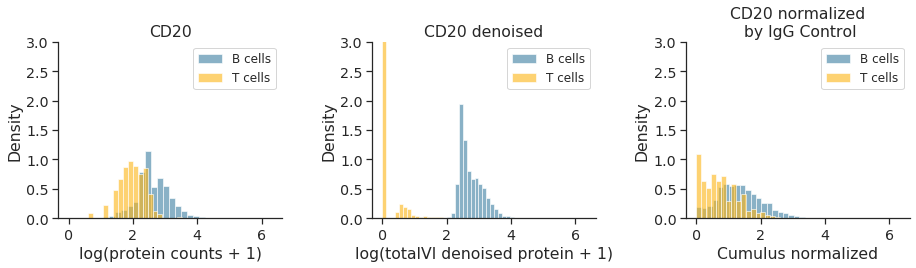

In [69]:
for RNA_name in ["Ms4a1"]:
    fig, ax = plt.subplots(1, 3, figsize=(13, 4), sharex = True, ) # 1,2 9,4
    num_bins = 30
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]
    
    # Plot raw proteins (log(counts + 1))
    
    # B cells
    ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )
    
    ax[0].legend(loc='upper right', prop={'size': 12})
    ax[0].set(ylabel = "Density")
    ax[0].set(xlabel = "log(protein counts + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[0].set_title(protein_title)
    ax[0].set_ylim((0, 3)) # truncate at 3 for clarity

    
    # Plot denoised proteins (log(denoised + 1))
    
    # B cells
    ax[1].hist(np.log1p(adata.obsm["denoised_proteins"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[1].hist(np.log1p(adata.obsm["denoised_proteins"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )

    ax[1].legend(loc='upper right', prop={'size': 12})
    ax[1].set(ylabel = "Density")
    ax[1].set(xlabel = "log(totalVI denoised protein + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[1].set_title(protein_title + " denoised")
    ax[1].set_ylim((0, 3)) # truncate at 3 for clarity
    
    
    
    # Plot cumulus denoising
    # B cells
    ax[2].hist((norm_prot_df[protein][bcells]), # [bcells]
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[2].hist((norm_prot_df[protein][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )

    ax[2].legend(loc='upper right', prop={'size': 12})
    ax[2].set(ylabel = "Density")
    ax[2].set(xlabel = "Cumulus normalized")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[2].set_title(protein_title + " normalized\n by IgG Control")
    ax[2].set_ylim((0, 3)) # truncate at 3 for clarity
  
    
    sns.despine()
    plt.tight_layout()

    #fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_208day1/Denoised_BT_%s_histogram_cumulus.png" % protein_title, dpi=DPI, bbox_inches='tight')

### GMM cutoff

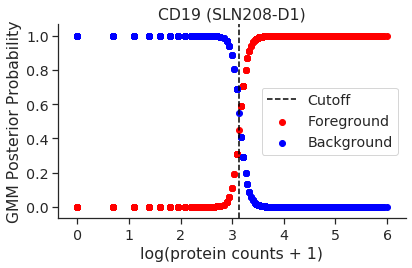

In [51]:
# Plot CD19 fore/back GMM probability monotonicity

prot_idx = np.where(adata.uns["totalVI_proteins"] == "ADT_CD19_A0093")[0][0]
gmm_fore = post_probs[:, prot_idx]
gmm_back = prob_back[:, prot_idx]

cutoff_idx = (np.abs(gmm_fore - 0.5)).argmin()
gmm_cutoff = np.log1p(adata.obsm["protein_expression"][:, prot_idx][cutoff_idx])


fig, ax = plt.subplots(figsize=(6,4)) 


ax.scatter(np.log1p(adata.obsm["protein_expression"][:, prot_idx]), gmm_fore, # foreground["ADT_CD20_A0192"], #
           #s = 1, 
           color  = 'red', label = "Foreground", rasterized = True)
ax.scatter(np.log1p(adata.obsm["protein_expression"][:, prot_idx]), gmm_back, # foreground["ADT_CD20_A0192"], #
          #s = 1, 
           color = 'blue', label = "Background", rasterized = True)
ax.axvline(x = gmm_cutoff, linestyle="--", c="black", label = "Cutoff")


ax.set(ylabel = "GMM Posterior Probability")
ax.set(xlabel = "log(protein counts + 1)")
ax.set(title = "CD19 (SLN208-D1)")
ax.legend()

sns.despine()
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_208day1/GMM_probabilities_cutoff.pdf", dpi=DPI, bbox_inches='tight')
#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_208day1/GMM_probabilities_cutoff.png", dpi=DPI, bbox_inches='tight')